In [1]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras import optimizers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Standardized Data incl 0 output

In [3]:
train_df = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/train_stdf.csv')

In [4]:
train_df.head()

,Year,Month,Day,Hour,GHI,TmpF,output,dew,humidity,precip,...,"Ice, Overcast",Overcast,Partially cloudy,Rain,"Rain, Overcast","Rain, Partially cloudy","Snow, Overcast","Snow, Partially cloudy","Snow, Rain, Overcast","Snow, Rain, Partially cloudy"
0,2016,10,1,0,0.000000,56.997313,0.0,53.3,87.78,0.025,...,0,0,0,0,0,1,0,0,0,0
1,2016,10,1,1,0.000000,56.929524,0.0,53.3,91.47,0.005,...,0,0,0,0,1,0,0,0,0,0
2,2016,10,1,2,0.001702,57.055018,0.0,54.0,93.96,0.000,...,0,1,0,0,0,0,0,0,0,0
3,2016,10,1,3,0.065986,57.198007,1.0,54.0,92.12,0.021,...,0,0,0,0,1,0,0,0,0,0
4,2016,10,1,4,0.163879,57.340995,0.0,54.1,93.36,0.000,...,0,1,0,0,0,0,0,0,0,0


In [5]:
train_df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'GHI', 'TmpF', 'output', 'dew',
       'humidity', 'precip', 'snow', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'date', 'Clear',
       'Freezing Drizzle/Freezing Rain, Overcast', 'Ice, Overcast', 'Overcast',
       'Partially cloudy', 'Rain', 'Rain, Overcast', 'Rain, Partially cloudy',
       'Snow, Overcast', 'Snow, Partially cloudy', 'Snow, Rain, Overcast',
       'Snow, Rain, Partially cloudy'],
      dtype='object')

In [6]:
x_train=train_df.drop(['Year','date','output'],axis=1)
y_train= train_df['output']

In [7]:
x_train.shape

(37273, 25)

In [8]:
test_df  = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/test_stdf.csv')
x_test=test_df.drop(['Year','date','output'],axis=1)
y_test= test_df['output']

In [9]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [10]:
num_steps = 3
# training set
(x_train_transformed,
 y_train_transformed) = lstm_data_transform(x_train, y_train, num_steps=num_steps)
assert x_train_transformed.shape[0] == y_train_transformed.shape[0]
# test set
(x_test_transformed,
 y_test_transformed) = lstm_data_transform(x_test, y_test, num_steps=num_steps)
assert x_test_transformed.shape[0] == y_test_transformed.shape[0]

In [11]:
valid_df = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/val_stdf.csv')
x_valid=valid_df.drop(['Year','date','output'],axis=1)
y_valid= valid_df['output']

In [12]:
# test set
(x_valid_transformed,
 y_valid_transformed) = lstm_data_transform(x_valid, y_valid, num_steps=num_steps)
assert x_valid_transformed.shape[0] == y_valid_transformed.shape[0]

In [13]:
y_test_transformed

array([0., 0., 0., ..., 0., 0., 0.])

In [14]:
x_train_transformed

array([[[10.,  1.,  0., ...,  0.,  0.,  0.],
        [10.,  1.,  1., ...,  0.,  0.,  0.],
        [10.,  1.,  2., ...,  0.,  0.,  0.]],

       [[10.,  1.,  1., ...,  0.,  0.,  0.],
        [10.,  1.,  2., ...,  0.,  0.,  0.],
        [10.,  1.,  3., ...,  0.,  0.,  0.]],

       [[10.,  1.,  2., ...,  0.,  0.,  0.],
        [10.,  1.,  3., ...,  0.,  0.,  0.],
        [10.,  1.,  4., ...,  0.,  0.,  0.]],

       ...,

       [[12., 31., 19., ...,  0.,  0.,  0.],
        [12., 31., 20., ...,  0.,  0.,  0.],
        [12., 31., 21., ...,  0.,  0.,  0.]],

       [[12., 31., 20., ...,  0.,  0.,  0.],
        [12., 31., 21., ...,  0.,  0.,  0.],
        [12., 31., 22., ...,  0.,  0.,  0.]],

       [[12., 31., 21., ...,  0.,  0.,  0.],
        [12., 31., 22., ...,  0.,  0.,  0.],
        [12., 31., 23., ...,  0.,  0.,  0.]]])

In [15]:
y_train_transformed

array([1., 0., 0., ..., 0., 0., 0.])

In [16]:

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [17]:
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten

In [18]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding = 'causal', activation='relu', input_shape=(x_train_transformed.shape[1], x_train_transformed.shape[2])))
model.add(MaxPooling1D(pool_size=1, strides=2))
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding = 'causal', activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=2))
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding = 'causal', activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=2))

model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=1, activation='linear'))
adam = optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae',r2_keras])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             4864      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             24640     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 64)            0

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
model_path = 'data298_cnn+lstm_v1.h5'

In [20]:
history= model.fit(x_train_transformed, y_train_transformed, epochs=50,verbose=2,validation_data=(x_valid_transformed,y_valid_transformed),
                   callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

Epoch 1/50
1165/1165 - 10s - loss: 11789245.0000 - mae: 1965.0073 - r2_keras: -3.2418e-01 - val_loss: 12772235.0000 - val_mae: 2028.1722 - val_r2_keras: -8.3323e+09 - 10s/epoch - 8ms/step
Epoch 2/50
1165/1165 - 7s - loss: 9503961.0000 - mae: 2202.6562 - r2_keras: -7.8112e-02 - val_loss: 12283896.0000 - val_mae: 2048.6345 - val_r2_keras: -4.1655e+10 - 7s/epoch - 6ms/step
Epoch 3/50
1165/1165 - 7s - loss: 9030704.0000 - mae: 2395.5095 - r2_keras: -4.7320e-02 - val_loss: 12177186.0000 - val_mae: 2054.5596 - val_r2_keras: -5.2965e+10 - 7s/epoch - 6ms/step
Epoch 4/50
1165/1165 - 6s - loss: 9021279.0000 - mae: 2428.5596 - r2_keras: -4.4374e-02 - val_loss: 12176974.0000 - val_mae: 2054.6255 - val_r2_keras: -5.2948e+10 - 6s/epoch - 5ms/step
Epoch 5/50
1165/1165 - 6s - loss: 9021218.0000 - mae: 2428.9355 - r2_keras: -4.0637e-02 - val_loss: 12171742.0000 - val_mae: 2054.9351 - val_r2_keras: -5.3549e+10 - 6s/epoch - 5ms/step
Epoch 6/50
1165/1165 - 6s - loss: 9021038.0000 - mae: 2433.1428 - r2_ker

In [21]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mae', 'r2_keras', 'val_loss', 'val_mae', 'val_r2_keras'])


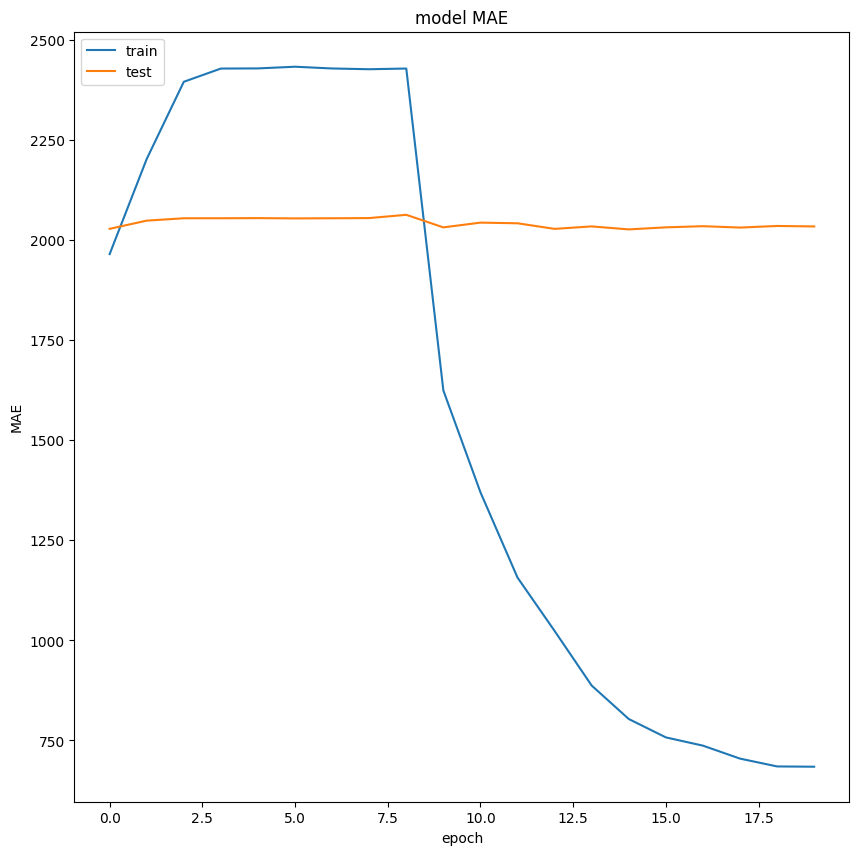

In [22]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
y_pred = model.predict(x_test_transformed)

320/320 [==============================] - 1s 3ms/step


In [31]:
test_data = x_test_transformed[1235:1236]
from time import process_time
t1_start = process_time() 
test_prediction = model.predict(test_data)
t1_stop = process_time()

print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:",
                                         t1_stop-t1_start) 

1/1 [==============================] - 0s 37ms/step
Elapsed time: 250.715226531 250.617670101
Elapsed time during the whole program in seconds: 0.09755643000002578


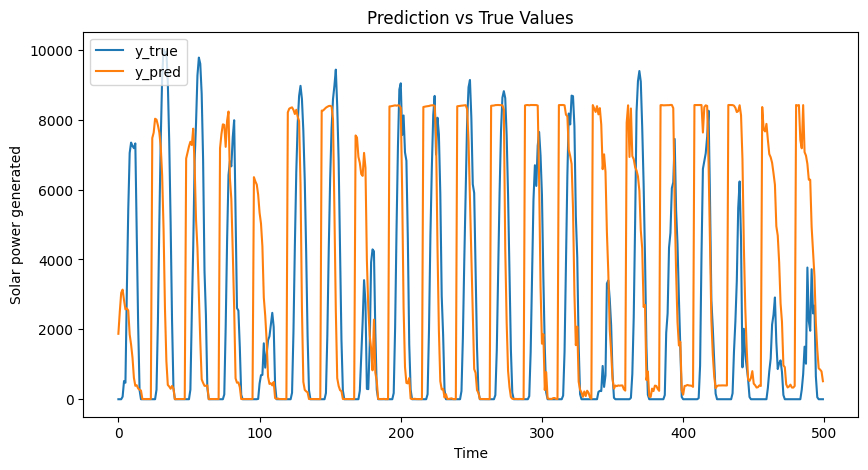

In [24]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 5))
plt.plot(y_test_transformed[:500])
plt.plot(y_pred[:500])
plt.title('Prediction vs True Values')
plt.ylabel('Solar power generated')
plt.xlabel('Time')
plt.legend(['y_true', 'y_pred'], loc='upper left')
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [26]:
mean_absolute_percentage_error(y_test_transformed, y_pred)

3.9739295952575315e+17

In [27]:
mean_absolute_error(y_test_transformed, y_pred)

760.5949504634146

In [28]:
mean_squared_error(y_test_transformed, y_pred,squared=False)

1576.2647275973331

In [29]:
r2_score(y_test_transformed, y_pred)

0.7190974856771539

### Standardized Data No 0 output

In [ ]:
train_df = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/train_df_no0_scaled.csv')

In [ ]:
train_df.head()

,Year,Month,Day,Hour,GHI,TmpF,output,dew,humidity,precip,snow,sealevelpressure,cloudcover,visibility,solarradiation,date
0,2016,10,1,3,-1.143079,-0.272506,1.0,0.325886,1.492652,0.514650,-0.045143,-0.208282,1.403860,-3.059949,-1.046464,2016-10-01
1,2016,10,1,7,-1.064765,-0.240862,208.0,0.331360,1.382033,-0.176102,-0.045143,-0.223053,1.469317,-1.842624,-1.045319,2016-10-01
2,2016,10,1,8,-1.076574,-0.217895,193.0,0.380626,1.423381,-0.176102,-0.045143,-0.163969,1.469317,-2.451286,-0.901080,2016-10-01
3,2016,10,1,9,-0.855667,-0.185494,971.0,0.391574,1.392235,-0.176102,-0.045143,-0.090114,1.469317,-3.181681,-0.640839,2016-10-01
4,2016,10,1,10,-0.614201,-0.140744,1847.0,0.424419,1.339074,-0.176102,-0.045143,-0.075343,1.469317,-2.573019,-0.622523,2016-10-01


In [ ]:
train_df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'GHI', 'TmpF', 'output', 'dew',
       'humidity', 'precip', 'snow', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'date'],
      dtype='object')

In [ ]:
x_train=train_df.drop(['Year','date','output'],axis=1)
y_train= train_df['output']

In [ ]:
x_train.shape

(19441, 13)

In [ ]:
test_df  = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/test_df_no0_scaled.csv')
x_test=test_df.drop(['Year','date','output'],axis=1)
y_test= test_df['output']

In [ ]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [ ]:
num_steps = 3
# training set
(x_train_transformed,
 y_train_transformed) = lstm_data_transform(x_train, y_train, num_steps=num_steps)
assert x_train_transformed.shape[0] == y_train_transformed.shape[0]
# test set
(x_test_transformed,
 y_test_transformed) = lstm_data_transform(x_test, y_test, num_steps=num_steps)
assert x_test_transformed.shape[0] == y_test_transformed.shape[0]

In [ ]:
valid_df = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/val_df_no0_scaled.csv')
x_valid=valid_df.drop(['Year','date','output'],axis=1)
y_valid= valid_df['output']

In [ ]:
# test set
(x_valid_transformed,
 y_valid_transformed) = lstm_data_transform(x_valid, y_valid, num_steps=num_steps)
assert x_valid_transformed.shape[0] == y_valid_transformed.shape[0]

In [ ]:
y_test_transformed

array([3120., 5432., 7048., ...,  824.,  360.,   88.])

In [ ]:
x_train_transformed

array([[[10.        ,  1.        ,  3.        , ...,  1.40386037,
         -3.05994861, -1.04646369],
        [10.        ,  1.        ,  7.        , ...,  1.46931729,
         -1.84262403, -1.04531894],
        [10.        ,  1.        ,  8.        , ...,  1.46931729,
         -2.45128632, -0.90107996]],

       [[10.        ,  1.        ,  7.        , ...,  1.46931729,
         -1.84262403, -1.04531894],
        [10.        ,  1.        ,  8.        , ...,  1.46931729,
         -2.45128632, -0.90107996],
        [10.        ,  1.        ,  9.        , ...,  1.46931729,
         -3.18168107, -0.64083926]],

       [[10.        ,  1.        ,  8.        , ...,  1.46931729,
         -2.45128632, -0.90107996],
        [10.        ,  1.        ,  9.        , ...,  1.46931729,
         -3.18168107, -0.64083926],
        [10.        ,  1.        , 10.        , ...,  1.46931729,
         -2.57301878, -0.6225232 ]],

       ...,

       [[12.        , 31.        , 12.        , ...,  1.4693172

In [ ]:
y_train_transformed

array([ 971., 1847., 2372., ...,  400.,  216.,   16.])

In [ ]:

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding = 'causal', activation='relu', input_shape=(x_train_transformed.shape[1], x_train_transformed.shape[2])))
model.add(MaxPooling1D(pool_size=1, strides=2))
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding = 'causal', activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=2))
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding = 'causal', activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=2))
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding = 'causal', activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=2))

model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=1, activation='linear'))
adam = optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae',r2_keras])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 3, 64)             2560      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 2, 128)            24704     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 128)            49280     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 128)          

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model_path = 'data298_lstm.h5'

In [ ]:
history= model.fit(x_train_transformed, y_train_transformed, epochs=50,verbose=2,validation_data=(x_valid_transformed,y_valid_transformed),
                   callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

Epoch 1/50
608/608 - 10s - loss: 23874916.0000 - mae: 3643.5144 - r2_keras: -1.3045e+00 - val_loss: 22783676.0000 - val_mae: 3550.3115 - val_r2_keras: -1.4860e+00 - 10s/epoch - 16ms/step
Epoch 2/50
608/608 - 4s - loss: 21033778.0000 - mae: 3363.5618 - r2_keras: -1.0275e+00 - val_loss: 19028610.0000 - val_mae: 3208.6538 - val_r2_keras: -1.3459e+00 - 4s/epoch - 7ms/step
Epoch 3/50
608/608 - 5s - loss: 17090696.0000 - mae: 3053.3418 - r2_keras: -6.4662e-01 - val_loss: 15099277.0000 - val_mae: 2953.3752 - val_r2_keras: -2.1775e+00 - 5s/epoch - 8ms/step
Epoch 4/50
608/608 - 4s - loss: 13701102.0000 - mae: 2877.6772 - r2_keras: -3.1587e-01 - val_loss: 12293535.0000 - val_mae: 2822.0872 - val_r2_keras: -4.2560e+00 - 4s/epoch - 7ms/step
Epoch 5/50
608/608 - 4s - loss: 11678288.0000 - mae: 2823.4575 - r2_keras: -1.2398e-01 - val_loss: 10933079.0000 - val_mae: 2804.2966 - val_r2_keras: -6.9268e+00 - 4s/epoch - 7ms/step
Epoch 6/50
608/608 - 5s - loss: 10888499.0000 - mae: 2842.6206 - r2_keras: -4

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mae', 'r2_keras', 'val_loss', 'val_mae', 'val_r2_keras'])


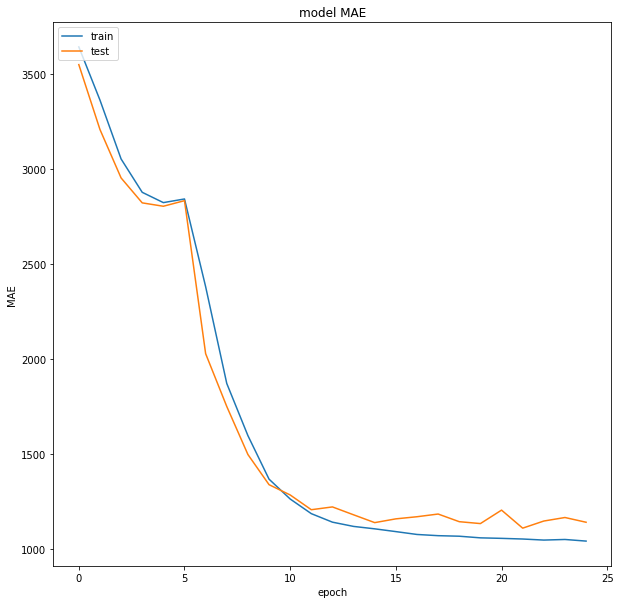

In [ ]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(x_test_transformed)

165/165 [==============================] - 1s 3ms/step


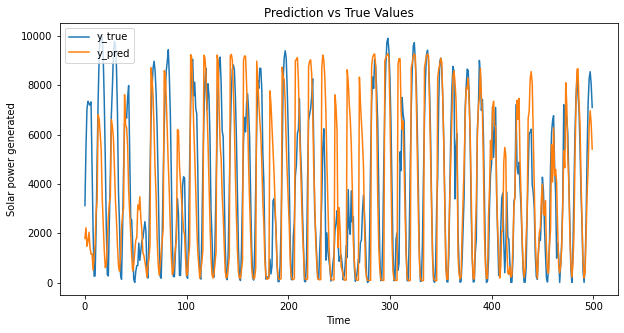

In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 5))
plt.plot(y_test_transformed[:500])
plt.plot(y_pred[:500])
plt.title('Prediction vs True Values')
plt.ylabel('Solar power generated')
plt.xlabel('Time')
plt.legend(['y_true', 'y_pred'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
mean_absolute_percentage_error(y_test_transformed, y_pred)

1.6970813265250528

In [ ]:
mean_absolute_error(y_test_transformed, y_pred)

1064.6186178855721

In [ ]:
mean_squared_error(y_test_transformed, y_pred,squared=False)

1601.6774872804992

In [ ]:
r2_score(y_test_transformed, y_pred)

0.7456695826374409

### Daily Data 


In [ ]:
train_df = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/train_daily_scaled.csv')

In [ ]:
train_df.head()

,date,GHI,TmpF,dew,humidity,snow,sealevelpressure,cloudcover,visibility,solarradiation,precip,output,year,month,day
0,2016-10-01,-0.911144,0.189517,0.543633,1.533085,-0.133726,-0.190797,1.580204,-2.268354,-0.134032,-0.232540,23159.0,2016,10,1
1,2016-10-02,-0.547337,0.438511,0.685913,0.824246,-0.133726,-0.026193,1.760792,-0.181476,0.625929,-0.391188,34483.0,2016,10,2
2,2016-10-03,0.014224,0.493965,0.508993,0.368191,-0.133726,-0.002955,-0.338909,-1.218789,0.533475,-0.420033,52849.0,2016,10,3
3,2016-10-04,0.177402,0.706897,0.582691,-0.148064,-0.133726,-0.122373,-0.176146,0.533208,0.762740,-0.420033,59870.0,2016,10,4
4,2016-10-05,0.246676,0.796062,0.703815,-0.402916,-0.133726,0.075797,0.090207,0.659810,0.705958,-0.420033,62184.0,2016,10,5


In [ ]:
train_df.columns

Index(['date', 'GHI', 'TmpF', 'dew', 'humidity', 'snow', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'precip', 'output',
       'year', 'month', 'day'],
      dtype='object')

In [ ]:
x_train=train_df.drop(['year','date','output'],axis=1)
y_train= train_df['output']

In [ ]:
x_train.shape

(1553, 12)

In [ ]:
test_df  = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/test_daily_scaled.csv')
x_test=test_df.drop(['year','date','output'],axis=1)
y_test= test_df['output']

In [ ]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [ ]:
num_steps = 3
# training set
(x_train_transformed,
 y_train_transformed) = lstm_data_transform(x_train, y_train, num_steps=num_steps)
assert x_train_transformed.shape[0] == y_train_transformed.shape[0]
# test set
(x_test_transformed,
 y_test_transformed) = lstm_data_transform(x_test, y_test, num_steps=num_steps)
assert x_test_transformed.shape[0] == y_test_transformed.shape[0]

In [ ]:
valid_df = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/val_daily_scaled.csv')
x_valid=valid_df.drop(['year','date','output'],axis=1)
y_valid= valid_df['output']

In [ ]:
# test set
(x_valid_transformed,
 y_valid_transformed) = lstm_data_transform(x_valid, y_valid, num_steps=num_steps)
assert x_valid_transformed.shape[0] == y_valid_transformed.shape[0]

In [ ]:
y_test_transformed

array([5.4136e+04, 1.6200e+04, 6.7392e+04, 6.8768e+04, 2.6576e+04,
       6.8208e+04, 6.3832e+04, 6.3552e+04, 6.3544e+04, 5.6360e+04,
       6.3920e+04, 1.5112e+04, 6.3640e+04, 4.7600e+04, 5.3192e+04,
       2.9176e+04, 1.5280e+04, 2.1024e+04, 1.6928e+04, 6.7472e+04,
       7.2080e+04, 4.1208e+04, 6.9800e+04, 6.6704e+04, 5.9584e+04,
       5.4272e+04, 5.5968e+04, 5.8600e+04, 4.4328e+04, 2.1072e+04,
       3.8088e+04, 3.8144e+04, 1.9232e+04, 3.8312e+04, 4.4816e+04,
       5.3192e+04, 5.6424e+04, 5.7024e+04, 5.4112e+04, 1.8848e+04,
       4.4768e+04, 1.2360e+04, 6.5104e+04, 6.4888e+04, 6.3144e+04,
       6.0112e+04, 6.0416e+04, 2.9272e+04, 1.4792e+04, 3.8312e+04,
       4.1976e+04, 2.2616e+04, 4.0968e+04, 6.0680e+04, 1.0352e+04,
       2.5128e+04, 1.5176e+04, 3.1872e+04, 5.5984e+04, 4.0224e+04,
       4.1104e+04, 5.8368e+04, 5.8520e+04, 5.6856e+04, 5.2680e+04,
       5.4088e+04, 4.5008e+04, 4.9968e+04, 2.1384e+04, 4.0944e+04,
       1.7680e+04, 1.0696e+04, 3.4184e+04, 4.7136e+04, 3.0120e

In [ ]:
x_train_transformed

array([[[-9.11144050e-01,  1.89516753e-01,  5.43633426e-01, ...,
         -2.32540225e-01,  1.00000000e+01,  1.00000000e+00],
        [-5.47337495e-01,  4.38510837e-01,  6.85913471e-01, ...,
         -3.91188044e-01,  1.00000000e+01,  2.00000000e+00],
        [ 1.42240125e-02,  4.93965474e-01,  5.08993350e-01, ...,
         -4.20033102e-01,  1.00000000e+01,  3.00000000e+00]],

       [[-5.47337495e-01,  4.38510837e-01,  6.85913471e-01, ...,
         -3.91188044e-01,  1.00000000e+01,  2.00000000e+00],
        [ 1.42240125e-02,  4.93965474e-01,  5.08993350e-01, ...,
         -4.20033102e-01,  1.00000000e+01,  3.00000000e+00],
        [ 1.77402479e-01,  7.06896946e-01,  5.82690693e-01, ...,
         -4.20033102e-01,  1.00000000e+01,  4.00000000e+00]],

       [[ 1.42240125e-02,  4.93965474e-01,  5.08993350e-01, ...,
         -4.20033102e-01,  1.00000000e+01,  3.00000000e+00],
        [ 1.77402479e-01,  7.06896946e-01,  5.82690693e-01, ...,
         -4.20033102e-01,  1.00000000e+01,  4.000

In [ ]:
y_train_transformed

array([59870., 62184., 57207., ..., 39328., 20328.,  4920.])

In [ ]:

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding = 'causal', activation='relu', input_shape=(x_train_transformed.shape[1], x_train_transformed.shape[2])))
model.add(MaxPooling1D(pool_size=1, strides=2))
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding = 'causal', activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=2))
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding = 'causal', activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=2))
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding = 'causal', activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=2))

model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=1, activation='linear'))
adam = optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae',r2_keras])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 3, 64)             2368      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 2, 128)            24704     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 128)            49280     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 1, 128)          

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model_path_v3 = 'data298_daily_cnn+lstm.h5'

In [ ]:
history= model.fit(x_train_transformed, y_train_transformed, epochs=500,verbose=2,validation_data=(x_valid_transformed,y_valid_transformed),
                   callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

Epoch 1/500
49/49 - 0s - loss: 2414237952.0000 - mae: 42351.6836 - r2_keras: -3.0894e+00 - val_loss: 2611379712.0000 - val_mae: 44838.2383 - val_r2_keras: -6.3311e+00 - 488ms/epoch - 10ms/step
Epoch 2/500
49/49 - 1s - loss: 2401661952.0000 - mae: 42210.1680 - r2_keras: -3.0225e+00 - val_loss: 2598028544.0000 - val_mae: 44706.5273 - val_r2_keras: -6.2935e+00 - 558ms/epoch - 11ms/step
Epoch 3/500
49/49 - 1s - loss: 2388992256.0000 - mae: 42067.0078 - r2_keras: -2.9645e+00 - val_loss: 2584624128.0000 - val_mae: 44574.9570 - val_r2_keras: -6.2558e+00 - 543ms/epoch - 11ms/step
Epoch 4/500
49/49 - 1s - loss: 2376234752.0000 - mae: 41924.1367 - r2_keras: -2.9828e+00 - val_loss: 2571124224.0000 - val_mae: 44443.5234 - val_r2_keras: -6.2178e+00 - 544ms/epoch - 11ms/step
Epoch 5/500
49/49 - 1s - loss: 2363355392.0000 - mae: 41779.2383 - r2_keras: -3.0703e+00 - val_loss: 2557387264.0000 - val_mae: 44309.6641 - val_r2_keras: -6.1791e+00 - 555ms/epoch - 11ms/step
Epoch 6/500
49/49 - 1s - loss: 2350

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mae', 'r2_keras', 'val_loss', 'val_mae', 'val_r2_keras'])


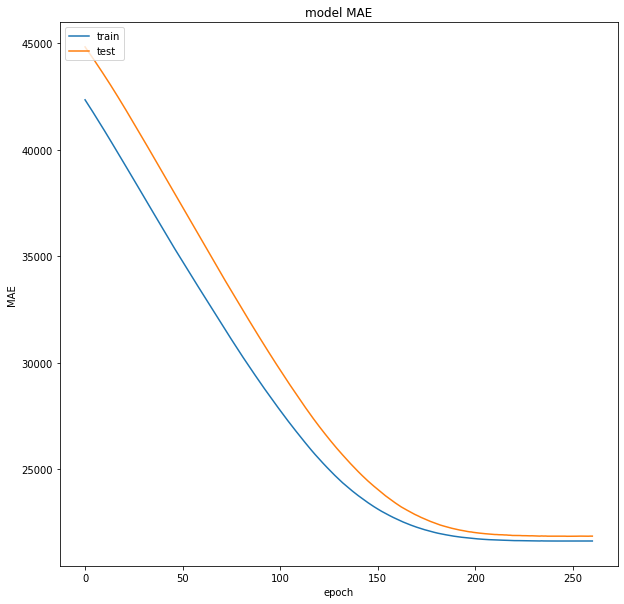

In [ ]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(x_test_transformed)

14/14 [==============================] - 1s 7ms/step


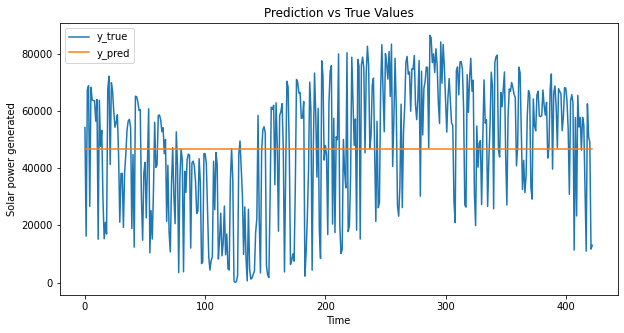

In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 5))
plt.plot(y_test_transformed[:500])
plt.plot(y_pred[:500])
plt.title('Prediction vs True Values')
plt.ylabel('Solar power generated')
plt.xlabel('Time')
plt.legend(['y_true', 'y_pred'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
mean_absolute_percentage_error(y_test_transformed, y_pred)

6.569737590618159

In [ ]:
mean_absolute_error(y_test_transformed, y_pred)

19238.258532801417

In [ ]:
mean_squared_error(y_test_transformed, y_pred,squared=False)

22652.644608434653

In [ ]:
r2_score(y_test_transformed, y_pred)

-0.0007728311460772908